<a href="https://colab.research.google.com/github/Agil0509/NLP/blob/main/MakeMore5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
!wget https://raw.githubusercontent.com/Rstam59/TaskDataRepoForStudents/refs/heads/main/names.txt

--2024-10-30 12:21:08--  https://raw.githubusercontent.com/Rstam59/TaskDataRepoForStudents/refs/heads/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-10-30 12:21:09 (9.92 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('/content/names.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
chars = sorted(set(''.join(words)))
stoi = {s: i+1 for i,s in enumerate(chars)}

stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [72]:
block_size = 8

def build_dataset(words):
  X,Y = [],[]

  for w in words:
    context = [0]*block_size
    for ch in w+'.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:]+[ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X,Y

n1 = int(0.8*(len(words)))
n2 = int(0.9*(len(words)))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [73]:
for x,y in zip(Xtr[:20],Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x),'---->',itos[y.item()])

........ ----> y
.......y ----> u
......yu ----> h
.....yuh ----> e
....yuhe ----> n
...yuhen ----> g
..yuheng ----> .
........ ----> d
.......d ----> i
......di ----> o
.....dio ----> n
....dion ----> d
...diond ----> r
..diondr ----> e
.diondre ----> .
........ ----> x
.......x ----> a
......xa ----> v
.....xav ----> i
....xavi ----> e


In [88]:
class Linear:

  def __init__(self,fan_in,fan_out,bias = True):
    self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5
    self.bias= torch.zeros(fan_out) if bias else None\

  def __call__(self,x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out+= self.bias
    return self.out

  def parameters(self):
    return [self.weight]+([] if self.bias is None else [self.bias])



class BatchNorm1d:
  def __init__(self,dim, eps = 1e-5,mommentum = 0.1):
    self.eps = eps
    self.mommentum=mommentum
    self.training = True
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      if x.ndim ==2:
        dim = 0
      elif x.ndim ==3:
        dim = (0,1)
      xmean = x.mean(dim,keepdim = True)
      xvar = x.var(dim,keepdim = True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat +self.beta
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.mommentum) * self.running_mean + self.mommentum * xmean
        self.running_var = (1-self.mommentum) * self.running_var + self.mommentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

class Tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


class Embedding:
  def __init__(self,num_embeddings,embedding_dim):
    self.weight = torch.randn((num_embeddings,embedding_dim))

  def __call__(self,IX):
    self.out = self.weight[IX]
    return self.out
  def parameters(self):
    return [self.weight]

class Flatten:

  def __call__(self,X):
    self.out = X.view(X.shape[0],-1)
    return self.out
  def parameters(self):
    return []


class Sequential:

  def __init__(self,layers):
    self.layers = layers

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


class FlattenConsecutive:

  def __init__(self,n):
    self.n= n

  def __call__(self,x):
    B,T,C= x.shape
    x = x.view(B,T//self.n,C*self.n)
    if x.shape[1] ==1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []




In [90]:
n_embd =10
n_hidden = 200

# C = torch.randn((vocab_size,n_embd))

model = Sequential([
    Embedding(vocab_size,n_embd),
    FlattenConsecutive(2),Linear(n_embd*2,n_hidden,bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias = False),BatchNorm1d(n_hidden),Tanh(),
    FlattenConsecutive(2),Linear(n_hidden*2,n_hidden,bias = False),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),])

with torch.no_grad():
  model.layers[-1].weight *= 0.1

parameters =  model.parameters()
print(sum(p.nelement() for p in parameters))


for p in parameters:
  p.requires_grad = True

170897


In [91]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  ix  = torch.randint(0,Xtr.shape[0],(batch_size,))
  Xb,Yb = Xtr[ix],Ytr[ix]

  # emb = C[Xb]
  # x = emb.view(emb.shape[0],-1)
  logits = model(Xb)
  loss = F.cross_entropy(logits,Yb)
  # for layer in m:
  #   x = layer(x)

  for p in parameters:
    p.grad = None
  loss.backward()

  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data +=-lr * p.grad


  if i % 10000 ==0:
    print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
  lossi.append(loss.log10().item())



      0/ 200000:3.2820
  10000/ 200000:1.8969
  20000/ 200000:2.3751
  30000/ 200000:2.1530
  40000/ 200000:1.8079
  50000/ 200000:1.9577
  60000/ 200000:1.6485
  70000/ 200000:2.1912
  80000/ 200000:2.0069
  90000/ 200000:2.1741
 100000/ 200000:2.1241
 110000/ 200000:1.7393
 120000/ 200000:2.0008
 130000/ 200000:2.2306
 140000/ 200000:1.9774
 150000/ 200000:2.3279
 160000/ 200000:1.8401
 170000/ 200000:1.6667
 180000/ 200000:2.0141
 190000/ 200000:1.8032


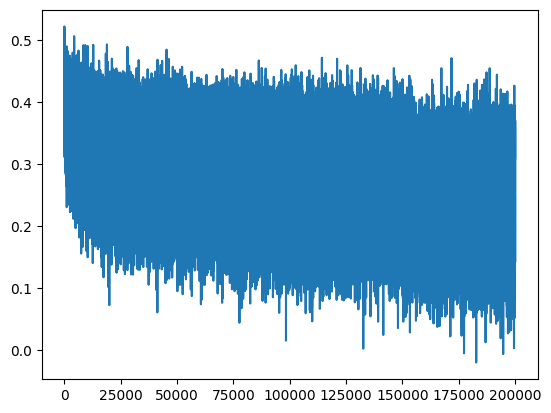

In [92]:
plt.plot(lossi)

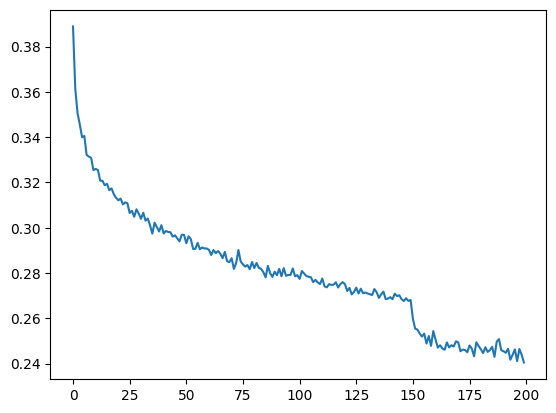

In [93]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [94]:
for layer in model.layers:
  layer.training = False


In [95]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    # emb = C[x]  # (batch_size, block_size, n_embd)
    # x = emb.view(emb.shape[0],-1)

    logits = model(x)
    loss = F.cross_entropy(logits,y)

    # # for layer in layers:
    # #   x = layer(x)
    # loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7332615852355957
val 1.9871954917907715


In [96]:
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        # emb = C[torch.tensor([context])]
        # x = emb.view(emb.shape[0], -1)
        x = torch.tensor([context])

        logits = model(x)
        probs = F.softmax(logits, dim = 1)
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

rionna.
karen.
androwni.
yidee.
josiyah.
dhyrn.
markemberlyn.
athalom.
kamerah.
khahita.
yuxi.
jadence.
emerlynn.
david.
lyric.
huml.
issak.
jayne.
augustin.
tilon.


In [97]:
ix = torch.randint(0,Xtr.shape[0],(4,))
Xb,Yb = Xtr[ix],Ytr[ix]
logits - model(Xb)
Xb

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [10,  1, 13,  1, 18,  9,  1,  8],
        [ 0,  0,  0, 10, 15, 21, 18,  4],
        [ 0,  0,  0,  0,  0,  0,  0, 12]])

In [98]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [99]:
model.layers[1].out.shape

torch.Size([4, 4, 20])

In [100]:
model.layers[2].out.shape

torch.Size([4, 4, 200])

In [101]:
e  = torch.randn(4,8,10)
explicit = torch.cat([e[:,::2,:],e[:,1::2,:]], dim = 2)

In [102]:
for layer in model.layers:
  print(layer.__class__.__name__, ':',tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [103]:
e = torch.randn(32,4,68)
emean = e.mean(0,keepdim = True)
evar = e.var(0,keepdim = True)
ehat = (e-emean)/torch.sqrt(evar -1e-5)
ehat.shape

torch.Size([32, 4, 68])